In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [ ]:
if IN_COLAB: 
    !pip install pandas
    !pip install numpy
    !pip install tensorflow
    !pip install -q -U keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
if IN_COLAB:
  !nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e5c31962-522f-2f5d-6ec8-52db42fda8ec)


In [ ]:
!pip freeze > requirements.txt

In [ ]:
if IN_COLAB:
  from google.colab import drive
  import sys
  drive.mount('/content/drive')
  sys.path.append('/content/drive/MyDrive')
  sys.path.append('/content/drive/MyDrive/swe-salary-predictor')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import time
import pandas as pd
from common import DataLoader
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MultiLabelBinarizer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:.2f}'.format
sns.set_theme(color_codes=True)

Preprocess and load dataset. See implementation of `DataLoader` in `analytics/common.py` for more details.

Changes from original include:
- `EdLevel` consolidated to 5 levels from 9
- `Age1stCode`, `Age`, `YearsCode`, `YearsCodePro` converted from strings representing ranges (e.g. `18-24 years old`) to integers
- Records from countries with less than 100 records in the survey were dropped
- Missing values were dropped or filled in with averages
- Salaries on the extreme high and low end of the spectrum were dropped.

In [ ]:
path = './data/stack-overflow-developer-survey-2021/survey_results_public.csv'
if IN_COLAB:
  path = './drive/MyDrive/swe-salary-predictor/survey_results_public.csv'

dl = DataLoader(path=path)
df = dl.df
df.head()

_start_pipeline:
  runtime=0:00:00.023391, end shape=(83439, 48)
_select:
  runtime=0:00:00.061434, end shape=(40627, 9)
_clean:
  runtime=0:00:00.154684, end shape=(40627, 9)
_remove_outliers:
  runtime=0:00:00.011627, end shape=(31610, 9)
_handle_missing:
  runtime=0:00:00.003902, end shape=(31610, 9)


,ConvertedCompYearly,EdLevel,Age1stCode,YearsCode,YearsCodePro,Country,DevType,LanguageHaveWorkedWith,Age
9,51552.00,Masters,14.00,7.00,4.00,Sweden,Data scientist or machine learning specialist,C++;Python,29.50
11,46482.00,Bachelors,14.00,12.00,5.00,Spain,"Developer, back-end",Bash/Shell;HTML/CSS;JavaScript;Node.js;SQL;Typ...,29.50
12,77290.00,Masters,14.00,15.00,6.00,Germany,"Developer, desktop or enterprise applications;...",C;C++;Java;Perl;Ruby,29.50
16,17748.00,Bachelors,7.50,6.00,2.00,Turkey,"Developer, full-stack",C#;HTML/CSS;Java;JavaScript;Node.js,29.50
17,46135.00,Bachelors,14.00,9.00,6.00,Canada,"Developer, front-end;Developer, full-stack;Dev...",Bash/Shell;HTML/CSS;JavaScript;PHP;Ruby;SQL,29.50


No missing values

In [ ]:
df.isna().sum()

ConvertedCompYearly       0
EdLevel                   0
Age1stCode                0
YearsCode                 0
YearsCodePro              0
Country                   0
DevType                   0
LanguageHaveWorkedWith    0
Age                       0
dtype: int64

Test out one hot encoding. Get first USA row and see that it's encoded correctly.

In [ ]:
row = df.loc[df['Country'] == "United States of America"].iloc[0]
country_us = row["Country"]
country_us_encoded = dl.encodings["Country"].transform(pd.DataFrame(data={"Country": [country_us]}))
country_us_encoded

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0.]])

# General Approach
To begin building the model, I will start with a simple baseline using a pretrained linear regression model on a subset of features. Then I will use a similar subset of features using a simple neural network. Finally, I will use the full subset of features and hyperparameter tuning to generate the final deep neural network.  

# Common Sense Baseline

We can get a baseline by using linear regression on a set of basic features. Here is a pretrained scikit learn linear regression model trained on `YearsCode`, `YearsCodePro`, `Age1stCode`, and `Age`.

In this case `neg_mean_absolute_error` is used as there is no `mean_absolute_error` option in sklearn's `cross_val_score` function.

In [ ]:
# test linear regression on basic features
X = df[['YearsCode', 'YearsCodePro', 'Age1stCode', 'Age']]
y = df['ConvertedCompYearly']
linreg = LinearRegression()
print(cross_val_score(linreg, X, y, cv=5, scoring="neg_mean_absolute_error"))

[-37379.26620951 -37701.65807953 -35740.49314329 -38083.74939931
 -35831.83772192]


This shows a result of about 37,000. This is above our target of 10% of the maximum possible salary of 300,000. Adding more features should improve this.

Here is another baseline using a one-hot encoded Country feature and the same pre-trained linear regression model from scikit learn.

In [ ]:
# make transformer for one hot encoding and use in pipeline.
# this doesn't actually use DataLoader.encoding['Country'] - maybe that's not needed?
column_trans = make_column_transformer(
    (OneHotEncoder(), ["Country"]),
    remainder="passthrough")
X = df[['YearsCode', 'YearsCodePro', 'Age1stCode', 'Age', 'Country']]
column_trans.fit_transform(X)
pipe = make_pipeline(column_trans, linreg)
cross_val_score(pipe, X, y, cv=5, scoring="neg_mean_absolute_error")

array([-25437.00572647, -24502.05810981, -22829.50701008, -25764.91851531,
       -24257.59982976])

This gives us a better score of about 25,000, which is just below our 10% of $300,000 target but we can likely do even better by building our own neural network and using the rest of the features. 

Before generating a baseline from building a simple keras model we need to divide our dataset into training and test sets.

In [ ]:
# Alternative Linear Regression baseline
dl = DataLoader(path=path)
df = dl.df.drop(['EdLevel', 'Country', 'DevType','LanguageHaveWorkedWith'], axis=1)
print(df.head())

train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)
train_features = train_dataset.copy()
test_features = test_dataset.copy()
train_labels = train_features.pop('ConvertedCompYearly')
test_labels = test_features.pop('ConvertedCompYearly')
train_dataset.describe().transpose()[['mean', 'std']]

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())


first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('First example Normalized:', normalizer(first).numpy())

_start_pipeline:
  runtime=0:00:00.015843, end shape=(83439, 48)
_select:
  runtime=0:00:00.052201, end shape=(40627, 9)
_clean:
  runtime=0:00:00.175226, end shape=(40627, 9)
_remove_outliers:
  runtime=0:00:00.011358, end shape=(31610, 9)
_handle_missing:
  runtime=0:00:00.004825, end shape=(31610, 9)
    ConvertedCompYearly  Age1stCode  YearsCode  YearsCodePro   Age
9              51552.00       14.00       7.00          4.00 29.50
11             46482.00       14.00      12.00          5.00 29.50
12             77290.00       14.00      15.00          6.00 29.50
16             17748.00        7.50       6.00          2.00 29.50
17             46135.00       14.00       9.00          6.00 29.50
[[16.05023  15.330842  9.626164 33.570713]]
First example: [[21.  10.   5.  29.5]]

First example Normalized: [[ 0.72 -0.57 -0.59 -0.46]]


Linear regression, excluding features that still need encoding.



In [ ]:
lr_model = keras.Sequential([
    normalizer,
    keras.layers.Dense(1)
])
lr_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 4)                9         
 n)                                                              
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 14
Trainable params: 5
Non-trainable params: 9
_________________________________________________________________


# Choosing the Right Loss Function

Why `mean_absolute_error`? 
- We don't care if the eror is positive or negative (hence, absolute)
- Mean Squared Error is often recommended for regression because it punishes large errors more. However, we have already removed outliers from the data (salaries less than 15,000 and more than 300,000) and I am relating it to the maximum salary, so I don't want to punish large errors more.

In [ ]:
lr_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss='mean_absolute_error'
)

In [ ]:
%%time
lr_history = lr_model.fit(
    train_features,
    train_labels,
    validation_split = 0.2,
    epochs=50,
    verbose=0)

MODELS = {
    "lr": lr_model.evaluate(test_features, test_labels, verbose=0)
}

print(MODELS["lr"])

78428.875
CPU times: user 1min 33s, sys: 15.4 s, total: 1min 49s
Wall time: 1min 6s


In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

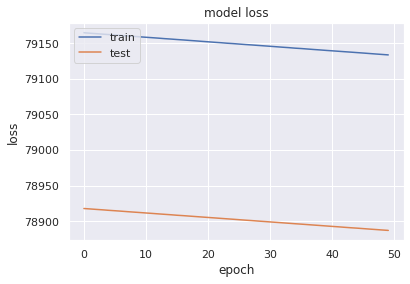

In [ ]:
plot_loss(lr_history)

This shows us what we need to see - the model is working bceause the train and test loss are decreasing. If we wanted to limit ourselves to this model we would need to train for more epochs until the train and test converge.

We can add a few more layers and train again.

In [ ]:
def build_model():
  model = keras.Sequential([
      normalizer,
      keras.layers.Dense(64, activation='relu'),
      keras.layers.Dense(64, activation='relu'),
      keras.layers.Dense(1)
  ])

  model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                loss='mean_absolute_error')
  return model

dnn1_model = build_model()
print(dnn1_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 4)                9         
 n)                                                              
                                                                 
 dense_1 (Dense)             (None, 64)                320       
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,554
Trainable params: 4,545
Non-trainable params: 9
_________________________________________________________________
None


In [ ]:
  %%time
  history1 = dnn1_model.fit(
      train_features,
      train_labels,
      validation_split=0.2, 
      epochs=50)
  
  MODELS['dnn1'] = dnn1_model.evaluate(test_features, test_labels, verbose=0)

  print(MODELS['dnn1'])

Epoch 1/50
633/633 [==============================] - 2s 3ms/step - loss: 77349.9453 - val_loss: 71425.2500
Epoch 2/50
633/633 [==============================] - 2s 3ms/step - loss: 57773.3164 - val_loss: 45354.4492
Epoch 3/50
633/633 [==============================] - 2s 3ms/step - loss: 42005.5273 - val_loss: 40369.4922
Epoch 4/50
633/633 [==============================] - 2s 3ms/step - loss: 39135.5430 - val_loss: 38548.5547
Epoch 5/50
633/633 [==============================] - 2s 2ms/step - loss: 37528.3633 - val_loss: 37293.2891
Epoch 6/50
633/633 [==============================] - 2s 3ms/step - loss: 36521.1016 - val_loss: 36538.2344
Epoch 7/50
633/633 [==============================] - 2s 3ms/step - loss: 35990.8672 - val_loss: 36127.7227
Epoch 8/50
633/633 [==============================] - 2s 3ms/step - loss: 35731.6055 - val_loss: 35919.6641
Epoch 9/50
633/633 [==============================] - 2s 3ms/step - loss: 35614.5000 - val_loss: 35817.3594
Epoch 10/50
633/633 [=======

# Validating our approach

The extra layers resulted in a much lower mean absolute error. We can see how this changed in our training over the epochs.

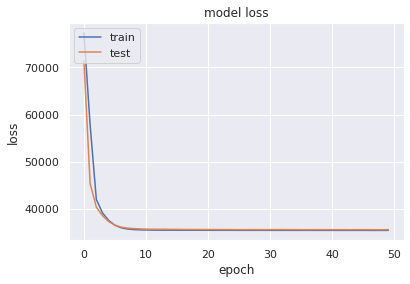

In [ ]:
plot_loss(history1)

We can take our testing using these subset of features a step further. We can redefine the `build_model` function. It now takes a `hp` parameter which will be used to make hyper parameters for the number of units in a layer (ranging from 32 to 256 with a step of 32) and the number of layers to add.

In [ ]:
def build_model(hp):
  model = keras.Sequential() # might need to be keras.models.Sequential() ??

  model.add(normalizer)
  model.add(keras.layers.Dense(hp.Int("units", min_value=32, max_value=256, step=32), activation='relu'))

  for i in range(hp.Int("n_layers", min_value=1, max_value=4)):
    model.add(keras.layers.Dense(hp.Int(f"units-{i}", min_value=32, max_value=256, step=32), activation='relu'))

  model.add(keras.layers.Dense(1))

  model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
      # loss='mean_squared_error'
      loss='mean_absolute_error')
  return model

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective = "val_loss",
    max_trials = 3,
    executions_per_trial = 1,
    # directory = f'${int(time.time())}'
)

In [ ]:
tuner.search(x=train_features,
             y=train_labels,
             epochs=10,
             batch_size=64,
             validation_data=(test_features, test_labels))

Trial 3 Complete [00h 00m 13s]
val_loss: 34816.77734375

Best val_loss So Far: 34816.77734375
Total elapsed time: 00h 00m 47s


In [ ]:
print(tuner.get_best_hyperparameters()[0].values)

{'units': 224, 'n_layers': 4, 'units-0': 160, 'units-1': 160, 'units-2': 96, 'units-3': 32}


In [ ]:
print(tuner.results_summary())

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
units: 224
n_layers: 4
units-0: 160
units-1: 160
units-2: 96
units-3: 32
Score: 34816.77734375
Trial summary
Hyperparameters:
units: 224
n_layers: 3
units-0: 160
units-1: 32
units-2: 32
Score: 34991.8046875
Trial summary
Hyperparameters:
units: 96
n_layers: 2
units-0: 160
units-1: 64
units-2: 192
Score: 35023.1328125
None


Now we can get the best model from our tuner using the `get_best_model` method.

In [ ]:
best_model = tuner.get_best_models()[0]
print(best_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 4)                9         
 n)                                                              
                                                                 
 dense (Dense)               (None, 224)               1120      
                                                                 
 dense_1 (Dense)             (None, 160)               36000     
                                                                 
 dense_2 (Dense)             (None, 160)               25760     
                                                                 
 dense_3 (Dense)             (None, 96)                15456     
                                                                 
 dense_4 (Dense)             (None, 32)                3104      
                                                        

Now we can fit our data to the `best_model` and compare with the results from our preliminary model (before hyperparameter tuning).

In [ ]:
  %%time
  history_best = best_model.fit(
      train_features,
      train_labels,
      validation_split=0.2, 
      epochs=25)
  
  MODELS['best'] = best_model.evaluate(test_features, test_labels, verbose=0)

  print(MODELS['best'])

Epoch 1/25
633/633 [==============================] - 2s 3ms/step - loss: 35466.1406 - val_loss: 35502.5117
Epoch 2/25
633/633 [==============================] - 2s 3ms/step - loss: 35444.5156 - val_loss: 35384.3242
Epoch 3/25
633/633 [==============================] - 2s 3ms/step - loss: 35409.2383 - val_loss: 35439.7109
Epoch 4/25
633/633 [==============================] - 2s 3ms/step - loss: 35382.5703 - val_loss: 35404.0938
Epoch 5/25
633/633 [==============================] - 2s 3ms/step - loss: 35376.6641 - val_loss: 35506.5898
Epoch 6/25
633/633 [==============================] - 2s 3ms/step - loss: 35383.6484 - val_loss: 35540.6328
Epoch 7/25
633/633 [==============================] - 2s 3ms/step - loss: 35392.0469 - val_loss: 35454.3906
Epoch 8/25
633/633 [==============================] - 2s 3ms/step - loss: 35366.1367 - val_loss: 35476.8438
Epoch 9/25
633/633 [==============================] - 2s 3ms/step - loss: 35394.6211 - val_loss: 35405.1641
Epoch 10/25
633/633 [=======

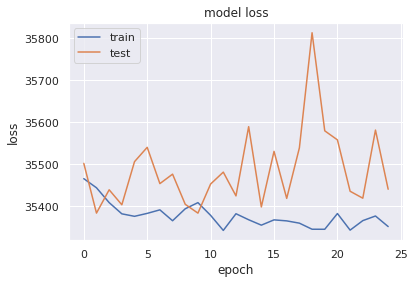

In [ ]:
plot_loss(history_best)

The score is pretty similar to our non hyper parameter tuned model. We should see more improvents from encoding the additional features.

# Predict

We can simply make predictions by passing in integers for `YearsCode`,`YearsCodePro`, `Age`, and `Age1stCode`. This is in contrast to what we need to do after we encode the additional features (which I will elaborate on further below).

In [ ]:
# should not need to be normalized for predicting.
# country should be OHE, else  OHE should be in model layer
pred_input = np.array([1, 1, 1, 1])
pred = best_model.predict(pred_input)[:, 0]
pred[0]

23319.648

# Make model using encoded features

These helper functions will be used to encode features of our dataset using one hot encoding, multilabel binarizer, or ordinal encoding. 

The ordinal encoding on `EdLevel` lets our model know that `Associates` is higher than `Less than Associates` for education level.

The one hot encoding of `Country` turns each country into a new column of 0 or 1 (value of `1` signify it is that country, with the others as `0`). We use one hot encoding because countries are equal alteranatives - they are not ordered like `EdLevel`.

The multilabel binarizer is applied to the categories which have string lists delimited by colons (`LanguagesHaveWorkedWith` and `DevType`). This creates a new column for all possible languages and developer types. A record with a list of like `"C++;Python;Assembly"` for `LanguagesHaveWorkedWith` will have a value of `1` for the `C++`, `Python`, and `Assembly` column and `0`'s for the rest.


In [ ]:
def transform_df_ohe_country(df):
  # returns df with countries as columns of 0 or 1

  # encode
  ohe = OneHotEncoder(categories = "auto")
  feature_arr = ohe.fit_transform(df[['Country']]).toarray()
  # merge encoded into df
  df = merge_ohe(df, ohe, feature_arr)
  # drop country
  df = df.drop(['Country'], axis=1)
  
  return df, ohe

def merge_ohe(df, ohe, feature_arr):
  feature_labels = np.array(ohe.categories_).ravel()
  df_features = pd.DataFrame(feature_arr, columns=feature_labels)
  df.reset_index(drop=True, inplace=True)
  df_features.reset_index(drop=True, inplace=True)
  df = pd.concat([df, df_features], axis=1)
  return df

def transform_df_mlb_delimited_string(df, column):
  # change delimited string to list
  df[column] = df[column].apply(lambda x: x.split(';'))

  mlb = MultiLabelBinarizer()
  encoded = mlb.fit_transform(df.pop(column))

  df = merge_mlb(df, mlb, encoded)
  
  return df, mlb
  
def merge_mlb(df, mlb, encoded):
  return df.join(pd.DataFrame(encoded, columns=mlb.classes_, index=df.index))  

def transform_df_oe(df):
  oe = OrdinalEncoder(categories=[['Less than Associates', 'Associates', 
                                   'Bachelors', 'Masters', 'Doctorate']])
  df['EdLevel'] = oe.fit_transform(df['EdLevel'].values.reshape(-1,1))
  return df, oe



Now we can encode the `Country`, `DevType`, and `LanguagesHaveWorkedWith` and split up our dataset into train and test sets.

Note the representation of `Country` and `LanguagesHaveWorkedWith` as independant columns (`Argentina`, `Australia`, etc. and `PowerShell`, `Python`, etc.) with binary values and `EdLevel` as range of integers.

In [ ]:
import pickle

df = dl.df
df, country_ohe = transform_df_ohe_country(df)
df, dev_type_mlb = transform_df_mlb_delimited_string(df, 'DevType')
df, languages_mlb = transform_df_mlb_delimited_string(df, 'LanguageHaveWorkedWith')
df, ed_level_oe = transform_df_oe(df)

encodings = {
  "country_ohe": country_ohe,
  "dev_type_mlb": dev_type_mlb,
  "languages_mlb": languages_mlb,
  "ed_level_oe": ed_level_oe
}

# save ohe
with open("encodings.pickle", "wb") as f: 
    pickle.dump(encodings, f)

train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)
train_features = train_dataset.copy()
test_features = test_dataset.copy()
train_labels = train_features.pop('ConvertedCompYearly')
test_labels = test_features.pop('ConvertedCompYearly')

train_features.head()

,EdLevel,Age1stCode,YearsCode,YearsCodePro,Age,Argentina,Australia,Austria,Belgium,Brazil,...,PowerShell,Python,R,Ruby,Rust,SQL,Scala,Swift,TypeScript,VBA
21426,3.00,21.00,10.00,5.00,29.50,0.00,0.00,0.00,0.00,0.00,...,0,0,0,1,0,1,0,0,0,0
18,2.00,21.00,12.00,6.00,29.50,0.00,0.00,0.00,0.00,0.00,...,1,0,0,0,0,0,0,0,1,1
18438,3.00,14.00,26.00,23.00,39.50,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,1,0
18322,3.00,14.00,25.00,10.00,39.50,0.00,0.00,0.00,0.00,0.00,...,0,1,0,0,0,0,0,0,0,0
13802,3.00,14.00,9.00,2.00,29.50,0.00,0.00,0.00,1.00,0.00,...,0,0,0,1,0,0,0,0,1,0


Here we can see a full lit of columns, which shows all the one-hot encoded `Country` and multi-labeled `LanguagesHaveWorkedWith` and `DevTypes`

In [ ]:
list(df.columns)

['ConvertedCompYearly',
 'EdLevel',
 'Age1stCode',
 'YearsCode',
 'YearsCodePro',
 'Age',
 'Argentina',
 'Australia',
 'Austria',
 'Belgium',
 'Brazil',
 'Bulgaria',
 'Canada',
 'Chile',
 'China',
 'Colombia',
 'Croatia',
 'Czech Republic',
 'Denmark',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Hungary',
 'India',
 'Iran, Islamic Republic of...',
 'Ireland',
 'Israel',
 'Italy',
 'Japan',
 'Lithuania',
 'Mexico',
 'Netherlands',
 'New Zealand',
 'Norway',
 'Poland',
 'Portugal',
 'Romania',
 'Russian Federation',
 'Serbia',
 'Singapore',
 'Slovenia',
 'South Africa',
 'Spain',
 'Sweden',
 'Switzerland',
 'Taiwan',
 'Turkey',
 'Ukraine',
 'United Kingdom of Great Britain and Northern Ireland',
 'United States of America',
 'Academic researcher',
 'Data or business analyst',
 'Data scientist or machine learning specialist',
 'Database administrator',
 'Designer',
 'DevOps specialist',
 'Developer, QA or test',
 'Developer, back-end',
 'Developer, desktop or enterprise applications',

Again, we can define the model using hyperparameters and explore this space with keras tuner.

The model starts iwth a dense layer between 32 and 256 units (with a step of 32) and a relu activation function.

Then it will have between 1 and 2 additional dense layers between 32 and 256 units (with a step of 32) and a relu activation function.

Finally, it will end with a single dense layer and use the Adams optimizer. The Adams optimzer does not need to by tuned with hyper parameters because it essentially does this internally already. 

In [ ]:
def build_model(hp):
  model = keras.Sequential()
  model.add(keras.layers.Dense(hp.Int("units", min_value=32, max_value=256, step=32), activation='relu'))

  for i in range(hp.Int("n_layers", min_value=1, max_value=3)):
    model.add(keras.layers.Dense(hp.Int(f"units-{i}", min_value=32, max_value=256, step=32), activation='relu'))

  model.add(keras.layers.Dense(1))

  model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
      # loss='mean_squared_error'
      loss='mean_absolute_error')

  return model

Now we initialize and search the tuner using our `build_model` function. It will user `RandomSearch` to look for the best `val_loss`.

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective = "val_loss",
    max_trials = 3,
    executions_per_trial = 1,
    directory = f'${int(time.time())}'
)

In [ ]:
tuner.search(x=train_features,
             y=train_labels,
             epochs=10,
             batch_size=64,
             validation_data=(test_features, test_labels))

Trial 3 Complete [00h 00m 12s]
val_loss: 22643.08203125

Best val_loss So Far: 21509.8984375
Total elapsed time: 00h 00m 35s


This shows the optimal parameters that the tuner found.

In [ ]:
print(tuner.get_best_hyperparameters()[0].values)
print(tuner.results_summary())

{'units': 160, 'n_layers': 3, 'units-0': 128, 'units-1': 160, 'units-2': 32}
Results summary
Results in $1661108281/untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
units: 160
n_layers: 3
units-0: 128
units-1: 160
units-2: 32
Score: 21509.8984375
Trial summary
Hyperparameters:
units: 160
n_layers: 2
units-0: 128
units-1: 32
Score: 21635.87890625
Trial summary
Hyperparameters:
units: 160
n_layers: 1
units-0: 224
units-1: 224
units-2: 160
Score: 22643.08203125
None


Now we will train the best model which the tuner found using out `test_features`. Here is a peak at the `test_features`.

In [ ]:
test_features.values

array([[ 2. , 28.5,  4. , ...,  0. ,  0. ,  0. ],
       [ 2. , 14. ,  8. , ...,  0. ,  0. ,  0. ],
       [ 3. ,  7.5, 34. , ...,  0. ,  1. ,  0. ],
       ...,
       [ 3. ,  7.5, 30. , ...,  0. ,  1. ,  0. ],
       [ 3. ,  7.5, 16. , ...,  0. ,  1. ,  0. ],
       [ 2. , 14. , 17. , ...,  0. ,  0. ,  0. ]])

In [ ]:
best_model = tuner.get_best_models()[0]

We will pass in an early stopping callback. We set a `patience` of 5 and instruct it to restore the best weights. This means the model will stop after 5 successive `val_loss`'s higher than the lowest `val_loss`. At this point it will restore the best weights and stop. This saves time and compute power.

In [ ]:
%%time
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True)
history_best = best_model.fit(
    train_features,
    train_labels,
    validation_split=0.2, 
    epochs=150,
    callbacks=[callback])

MODELS['best'] = best_model.evaluate(test_features, test_labels, verbose=0)

print(MODELS['best'])

Epoch 1/150
633/633 [==============================] - 2s 3ms/step - loss: 21617.4961 - val_loss: 22556.1289
Epoch 2/150
633/633 [==============================] - 2s 3ms/step - loss: 21454.3789 - val_loss: 21316.7363
Epoch 3/150
633/633 [==============================] - 2s 3ms/step - loss: 21420.7891 - val_loss: 21392.1699
Epoch 4/150
633/633 [==============================] - 2s 3ms/step - loss: 21351.6582 - val_loss: 21469.5000
Epoch 5/150
633/633 [==============================] - 2s 3ms/step - loss: 21348.3574 - val_loss: 21339.4727
Epoch 6/150
633/633 [==============================] - 2s 3ms/step - loss: 21269.4766 - val_loss: 21501.6113
Epoch 7/150
633/633 [==============================] - 2s 3ms/step - loss: 21224.5879 - val_loss: 21443.2637
21405.185546875
CPU times: user 18 s, sys: 2.51 s, total: 20.5 s
Wall time: 21.3 s


This shows a history of `loss` (train) and `val_loss` (test) over time, and our final model evaluation, which is well under our target of 10% of the max salary.

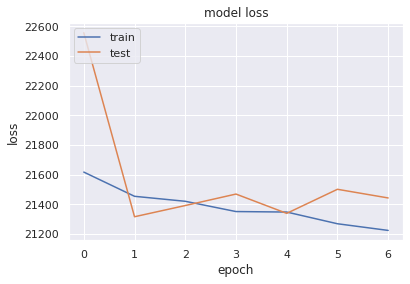

In [ ]:
plot_loss(history_best)

In [ ]:
best_model.evaluate(test_features, test_labels, verbose=0)

21405.185546875

In order to actually make a prediction, we will need to encode inputs the same way we encoded the dataframe.

If we just try to pass "United States of America" into the model for "Country", it won't know what to do because "Country" is no longer a column. Thus, we can use this `make_input` function which takes the inputs how we might expect to receive them and encodes them using the existing encodings we generated above.

This function is used in `./server/main` to generate predictions and in the `/api/untrained-inputs-encoded` endpoint to format saved inputs before being retrained. This is possibly because I have saved the encodings generated here and made them available to `server`.

In [ ]:
# # should not need to be normalized for predicting.
# # country should be OHE, else  OHE should be in model layer
def make_input(input_dict):
  df_input = pd.DataFrame(data={
      "EdLevel": [input_dict["ed_level"]], # will be transformed inplace below when encoded
      "Age1stCode": [input_dict["age_first_code"]],
      "YearsCode": [input_dict["years_code"]],
      "YearsCodePro": [input_dict["years_code_pro"]],
      "Age": [input_dict["age"]],
  })
  # encode Country
  country_enc = country_ohe.transform(pd.DataFrame(
      data={"Country": [input_dict["country"]]})).toarray()
  df = merge_ohe(df_input, country_ohe, country_enc)
  
  # encode Devtype
  dev_type_enc = dev_type_mlb.transform(pd.Series([input_dict["dev_type"]]))
  df = merge_mlb(df, dev_type_mlb, dev_type_enc)

  # encode LanguageHaveWorkedWith
  languages_enc = languages_mlb.transform(pd.Series([input_dict["languages"]]))
  df = merge_mlb(df, languages_mlb, languages_enc)

  # encode Edlevel
  df['EdLevel'] = ed_level_oe.transform(df['EdLevel'].values.reshape(-1,1))

  return df.values

pred_input = make_input({"age_first_code": 16, "years_code": 4,
                         "years_code_pro": 3, "age": 33, 
                         "country": "United States of America", 
                         "dev_type": ["Developer, full-stack"],
                         "languages": ["Python", "JavaScript", "SQL"],
                         "ed_level": "Bachelors"})
pred_input

array([[ 2., 16.,  4.,  3., 33.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])

Now we can make a prediction using our encoded input.

In [ ]:
pred = best_model.predict(pred_input)[:, 0]
pred[0]

101935.59

The model gets saved here so it can be used later.

In [ ]:
filename = f'./model_{int(time.time())}'
keras.models.save_model(best_model, filename)

This reloads the model from file, gives it the same input as above, and gets the same prediction. This shows that it was succesfully saved and loaded.

In [ ]:
saved_model = tf.keras.models.load_model(filename)

In [ ]:
saved_model.predict(pred_input)[0][0]

101935.59